<a href="https://colab.research.google.com/github/jyotheeswar42/Sales-forecasting-prophet/blob/main/SalesForecastingWithProphet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcio_qz2a/x7ak_doj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcio_qz2a/t3m8s5pr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92033', 'data', 'file=/tmp/tmpcio_qz2a/x7ak_doj.json', 'init=/tmp/tmpcio_qz2a/t3m8s5pr.json', 'output', 'file=/tmp/tmpcio_qz2a/prophet_model6xtnt88r/prophet_model-20250826042756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:27:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Libraries are ready.

Generated sales data. Here's a quick look:
          ds    y
0 2022-01-01  749
1 2022-01-02  796
2 2022-01-03  660
3 2022-01-04  653
4 2022-01-05  695

Custom events (holidays) dataframe created.

Training the Prophet model...


04:27:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model training complete.

Created a future dataframe for the next 365 days.

Forecast generated. Here are the last few predicted days:
             ds         yhat   yhat_lower   yhat_upper
1456 2025-12-27  1762.920279  1104.611597  2395.626078
1457 2025-12-28  1762.707394  1116.119164  2381.797105
1458 2025-12-29  1583.003605   927.783879  2213.601862
1459 2025-12-30  1584.717017   920.535428  2232.961495
1460 2025-12-31  1575.936834   925.184351  2207.430842

Generating forecast plot...


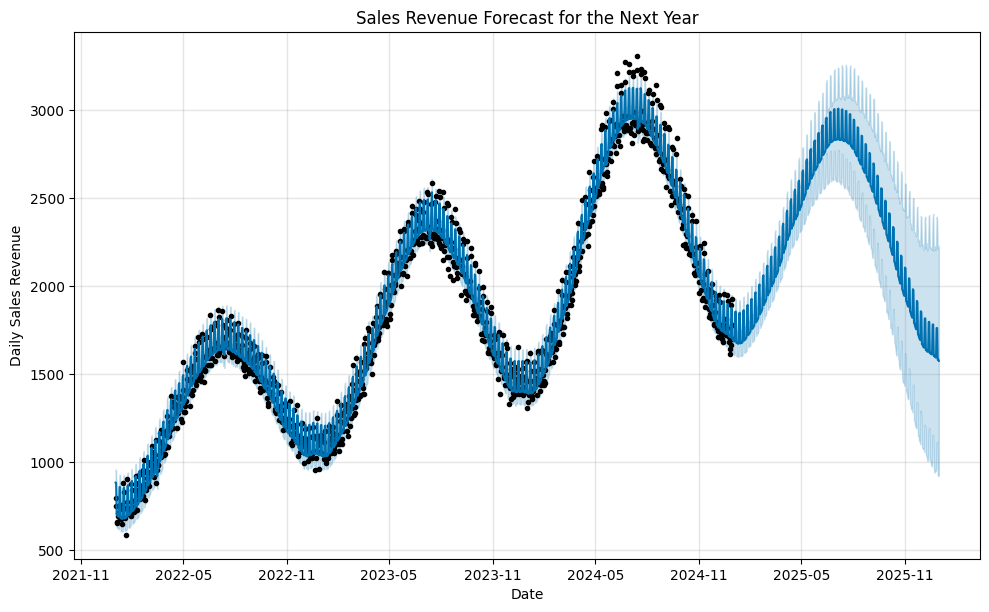


Generating forecast components plot...


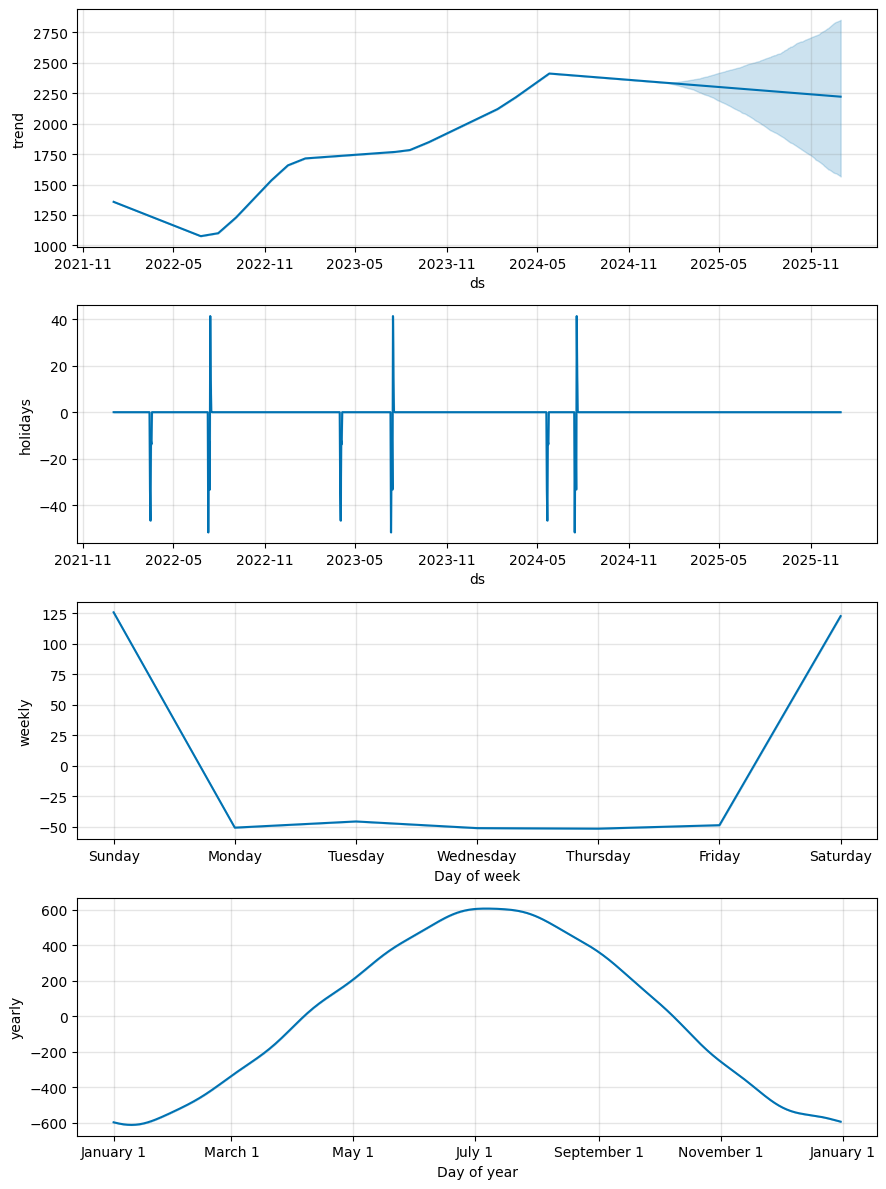

In [2]:
# ## Project: Sales Revenue Forecasting with Prophet
# This script builds a time-series model to forecast future sales.
# We're generating our own data to simulate a real-world scenario with
# trends, seasonality, and special company events.

# First, let's get our libraries sorted.
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

# A quick check to make sure Prophet is installed in the environment.
try:
    from prophet import Prophet
except ImportError:
    print("Prophet not found. Installing now...")
    !pip install prophet -q
    from prophet import Prophet

print("Libraries are ready.")


# --- Data Generation ---
# Instead of hunting for a perfect dataset, we'll create our own.
# This gives us full control and makes the script runnable anywhere.
def generate_sales_data():
    # We'll create a date range for three years of daily data.
    dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')
    n_points = len(dates)

    # Let's create a steady upward trend for our sales.
    trend = np.linspace(1000, 2500, n_points)

    # Sales usually have weekly and yearly patterns.
    # e.g., higher on weekends, peak during the holiday season.
    yearly_seasonality = 1 + 0.3 * np.sin(2 * np.pi * dates.dayofyear / 365.25 - np.pi/2)
    weekly_seasonality = 1 + 0.1 * (dates.dayofweek // 5) # Higher sales on weekends (Fri/Sat)

    # And of course, some random noise to make it realistic.
    noise = np.random.normal(0, 50, n_points)

    # Combine everything to get our final sales figures.
    sales = (trend * yearly_seasonality * weekly_seasonality) + noise
    sales = sales.astype(int)

    # Prophet needs columns named 'ds' (datestamp) and 'y' (the value we're forecasting).
    df = pd.DataFrame({'ds': dates, 'y': sales})
    return df

# Let's generate the data and see what it looks like.
df = generate_sales_data()
print("\nGenerated sales data. Here's a quick look:")
print(df.head())


# --- Incorporating Special Events ---
# This is a key step. Real-world sales are affected by promotions, holidays, etc.
# We'll create a separate dataframe to hold these events.
product_launches = pd.DataFrame({
  'holiday': 'product_launch',
  'ds': pd.to_datetime(['2022-03-15', '2023-04-01', '2024-05-20']),
  'lower_window': 0, # The event impacts the day of the launch
  'upper_window': 3, # ...and the next 3 days.
})

summer_sales = pd.DataFrame({
  'holiday': 'summer_sale',
  'ds': pd.to_datetime(['2022-07-10', '2023-07-12', '2024-07-15']),
  'lower_window': 0,
  'upper_window': 6, # A week-long sale event.
})

# Combine all our special events into one dataframe.
holidays = pd.concat((product_launches, summer_sales))
print("\nCustom events (holidays) dataframe created.")


# --- Building and Training the Model ---
# Now for the fun part. We'll initialize Prophet and pass our custom events to it.
# We're also letting it find the yearly and weekly seasonality automatically.
model = Prophet(
    holidays=holidays,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False # Daily patterns are usually just noise unless you have hourly data.
)

# Training is simple, just call the fit method on our data.
print("\nTraining the Prophet model...")
model.fit(df)
print("Model training complete.")


# --- Making Future Predictions ---
# We need to create a dataframe of future dates to predict on.
# Let's forecast for the next full year (365 days).
future = model.make_future_dataframe(periods=365)
print("\nCreated a future dataframe for the next 365 days.")

# Use the trained model to make the forecast.
forecast = model.predict(future)

# The forecast object is a big dataframe with lots of info.
# We're mostly interested in 'ds', 'yhat' (the prediction), and the uncertainty intervals.
print("\nForecast generated. Here are the last few predicted days:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


# --- Visualizing the Results ---
# Prophet has great built-in plotting functions.
print("\nGenerating forecast plot...")

# This first plot shows the historical data, the forecast, and the uncertainty interval.
fig1 = model.plot(forecast)
plt.title('Sales Revenue Forecast for the Next Year')
plt.xlabel('Date')
plt.ylabel('Daily Sales Revenue')
plt.show()

# This second plot breaks down the forecast into its components.
# You can see the overall trend, the effect of our custom holidays, and the seasonal patterns.
print("\nGenerating forecast components plot...")
fig2 = model.plot_components(forecast)
plt.show()